In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import seaborn as sns
import folium

地震の詳細  
日付: 地震が発生した日
時間: 発生時刻
Lat: 緯度
経度: 経度
深さ: 地震の深さ (km)
ML: 地震の規模
nstn: 測定に使用したステーションの数
Dmin: 最寄り駅までの距離（km）
ギャップ: 隣接するステーション間の最大ギャップ
RMS: 残差の二乗平均平方根誤差
ERH: 震源の水平標準偏差 (km)
ERZ: 震源深さの垂直標準偏差 (km)
修正: 深度制御 (F: 制限なし、X: 深度制限)
nph: 到着するフェーズの数
、品質: データの品質分類 (A、B、C、D)、
行: 各行は 1 回の地震発生に対応します。


災害地震.csv
属性:

日付: 災害発生日
場所: 影響を受ける地域全般
緯度: 震源地の緯度
経度: 震源地の経度
深さ: 地震の深さ (km)
マグニチュード: 地震の規模
死傷者数: 死亡した人数
負傷者数：負傷者数
行方不明者: 行方不明者の数
倒壊した建物: 倒壊した建物の数
行: 各行には過去の地震災害が記載されています。

In [2]:
df_disastrous = pd.read_csv('/kaggle/input/taiwan-earthquake-dataset/disastrous earthquake.csv')
df_disastrous.head(5)

,Date,Location,Latitude,Longitude,Depth (km),Magnitude,Casualties,Injured,Missing,Collapsed building
0,1720-10-31,Tainan,23.4,120.5,-,6.0,many deaths,NaN,NaN,NaN
1,1736-01-30,Tainan-Jiayi,23.1,120.3,-,7.0,372,NaN,NaN,689
2,1776-12-11,Jiayi,-,-,-,-,many deaths,NaN,NaN,NaN
3,1792-08-09,Nantou-Zhanghua-Jiayi,23.86,121.04,12.5,7.3,617,NaN,NaN,24621
4,1815-10-13/14,Jiayi-North,24.0,121.7,-,7.1,113,NaN,NaN,243


In [3]:
df_detail = pd.read_csv('/kaggle/input/taiwan-earthquake-dataset/earthquake detail.csv')
df_detail.head(5)

,date,time,lat,lon,depth,ML,nstn,dmin,gap,trms,ERH,ERZ,fixed,nph,quality
0,1973-01-02,04:53:55.80,22.8300,120.6700,15.0,2.88,6,41.0,153.0,0.19,1.3,6.2,N,6.0,C
1,1973-01-02,17:03:49.00,23.2700,120.5817,1.0,2.99,4,34.0,149.0,0.05,0.0,0.0,N,4.0,C
2,1973-01-03,08:36:36.60,23.1400,120.6150,10.0,4.10,5,49.0,138.0,0.24,3.3,4.1,N,5.0,D
3,1973-01-04,02:31:18.90,23.0350,120.2033,9.0,3.66,6,44.0,212.0,0.18,8.1,2.2,N,6.0,D
4,1973-01-06,15:28:45.80,24.8917,122.0167,5.0,3.10,4,45.0,283.0,0.11,0.0,0.0,N,4.0,C


In [4]:
#MLの５以上
df = df_detail[df_detail['ML'] >5]
# Foliumマップの中心を設定（例として台湾の中央付近）
m = folium.Map(location=[23.5, 121], zoom_start=8)

# マーカーをプロット
for i, row in df.iterrows():
    # 深さに応じたマーカーの色を設定（例: 深さが浅いほど赤、深いほど青）
    if row['depth'] <= 5:
        color = 'red'
    elif 5 < row['depth'] <= 10:
        color = 'orange'
    else:
        color = 'blue'

    # 地図にマーカーを追加
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"Date: {row['date']} Time: {row['time']}\nDepth: {row['depth']} km",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)

# 地図をJupyter Notebookで表示
display(m)

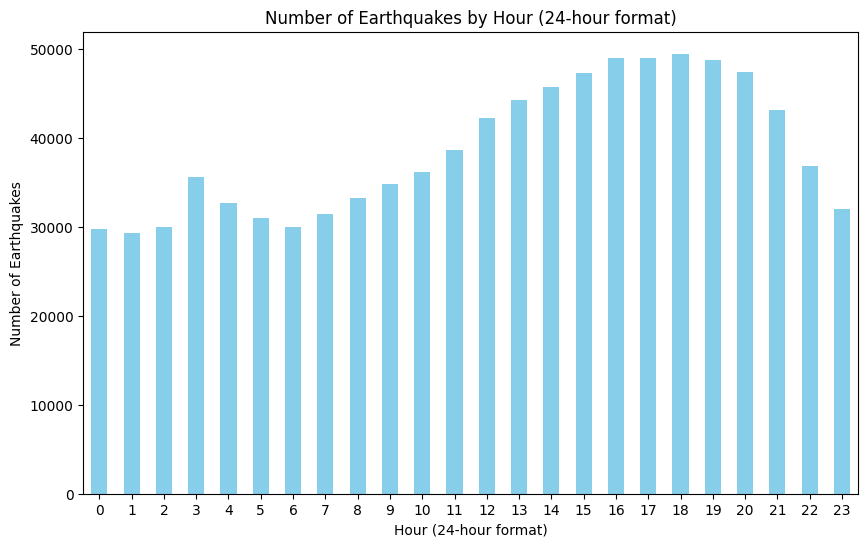

In [5]:
# 'time' カラムから時間だけを抽出する
df_detail['hour'] = pd.to_datetime(df_detail['time'], format='%H:%M:%S.%f').dt.hour

# 各時間帯ごとの地震の回数を数える
earthquake_count_by_hour = df_detail['hour'].value_counts().sort_index()

# 棒グラフを描く
plt.figure(figsize=(10, 6))
earthquake_count_by_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Earthquakes by Hour (24-hour format)')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=0)
plt.show()

In [6]:
import plotly.express as px
#  Casualties, Collapsed building, Magnitudeで小さい順にソート（欠損値を除外）
df_sorted = df_disastrous[['Casualties', 'Collapsed building', 'Magnitude']].dropna().sort_values(by=['Magnitude', 'Casualties', 'Collapsed building'])

# y軸の数字を整数にするために変換
df_sorted['Collapsed building'] = df_sorted['Collapsed building'].astype(int)

# plotlyでの散布図作成（Magnitudeを昇順にソート）
fig = px.scatter(df_sorted, x='Magnitude', y='Collapsed building', 
                 title='Magnitude vs Collapsed Buildings',
                 labels={'Magnitude': 'Magnitude', 'Collapsed building': 'Collapsed Buildings'})

# y軸のフォーマットを整数表示に
fig.update_yaxes(tickformat=',d')

# グラフの表示
fig.show()

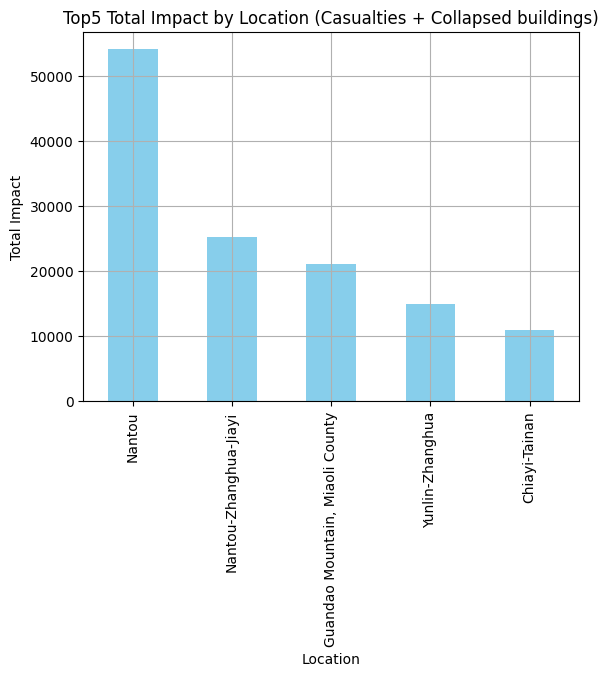

In [7]:
# CasualtiesとCollapsed buildingを数値型に変換
df_disastrous['Casualties'] = pd.to_numeric(df_disastrous['Casualties'], errors='coerce')
df_disastrous['Collapsed building'] = pd.to_numeric(df_disastrous['Collapsed building'], errors='coerce')

# 欠損値を補完
df_disastrous.fillna(0, inplace=True)

# 場所ごとに被害の合計（死者数 + 倒壊建物数）を計算
df_disastrous['Total Impact'] = df_disastrous['Casualties'] + df_disastrous['Collapsed building']

# 場所ごとに被害の合計を集計して、大きい順にソート
impact_by_location = df_disastrous.groupby('Location')['Total Impact'].sum().sort_values(ascending=False)
impact_five = impact_by_location[:5]


# 棒グラフで被害度合いを可視化
impact_five.plot(kind='bar', color='skyblue')

# グラフの設定
plt.title('Top5 Total Impact by Location (Casualties + Collapsed buildings)')
plt.xlabel('Location')
plt.ylabel('Total Impact')
plt.grid(True)
plt.show()